In [1]:
import tensorflow as tf
import numpy as np
from pyDOE import lhs
#from google.colab import drive, files
from netCDF4 import Dataset
import datetime

from scipy.io import savemat
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

from scipy.interpolate import griddata, RegularGridInterpolator
import matplotlib.pyplot as plt

import pandas as pd

2023-04-12 07:58:48.112072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 07:58:48.920153: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
ncfid = Dataset('hgt.1949.nc')

In [4]:
lon = list(ncfid['lon'][:]-180)
lat = list(ncfid['lat'][:])
level = list(ncfid['level'][:])
t = ncfid['time'][:]

In [5]:
# Convert time to date
basedate = datetime.datetime(1800, 1, 1, 0, 0, 0)
t = [basedate + datetime.timedelta(hours = t[i]) for i in range(len(t))]

In [6]:
# Read in fields for the ENIAC dates:
date1 = datetime.datetime(1949,1,5,0,0,0)
date2 = datetime.datetime(1949,1,30,0,0,0)
date3 = datetime.datetime(1949,1,31,0,0,0)
date4 = datetime.datetime(1949,2,13,0,0,0)

# Use the 500 hPa field
lev = 500

idx_time = t.index(date3)
idx_level = level.index(lev)

# Loads 24 hours of data on the required level
phi = ncfid['hgt'][idx_time:idx_time+5, idx_level,:,:]

# Convert to m^2 s^-2
phi = 9.81*phi

In [7]:
# Add longitude corresponding to 360 Deg so that data is periodic
lon = np.append(lon, lon[-1]+lon[1]-lon[0])
geo = np.append(phi, np.expand_dims(phi[:,:,0], axis=2), axis=2)

In [8]:
# Convert geopotential to streamfunction
Omega = 2*np.pi/86400
f0 = 2*Omega*np.sin(np.pi/4)
geo /= f0

In [9]:
# Data is flipped with respect to the ENIAC data so reverse that
geo = np.flip(geo, axis=1)
geo = np.flip(geo, axis=2)

In [10]:
# Convert lat and lon to radians
lon = np.pi*np.array(lon)/180
lat = np.pi*np.array(lat)/180

In [11]:
Lon, Lat = np.meshgrid(lon, lat)

# For plotting we need the data in degrees again
Lon_p = 180*Lon/np.pi
Lat_p = 180*Lat/np.pi

In [13]:
# Define an interpolant for the geopotential
psi0_interp = RegularGridInterpolator((np.flip(lat), lon), np.flipud(geo[0,]))#,
#                                      method='cubic')

In [14]:
# Parameters (Williamson et al)
a = 6.37122e6

# Scales of the problem
L = a
T = 86400
PSI = a**2/T
print(PSI)
# Boundaries of the computational domain
xleft, xright = lon.min(), lon.max()
ylower, yupper = lat.min(), lat.max()
t0, tfinal = 0, 86400

# Angular velocity
Omega = 2*np.pi/86400

# Initial condition (Non-dimensionalized)
psi0 = lambda y, x: (psi0_interp((x,y))-np.mean(geo[0,]))

469819957.0416667


In [15]:
# # Rossby Wave
# a, omega, K = 6.37122e6, 7.848e-6, 7.848e-6

# # Scales for re-scaling
# L = a
# T = 86400

# # Wave number
# R = 4

# # Scaling factor
# c = T/L**2
# psi0 = lambda x, y: (-a**2*omega*np.sin(y)+a**2*K*np.cos(y)**R*np.sin(y)*np.sin(R*x))*c

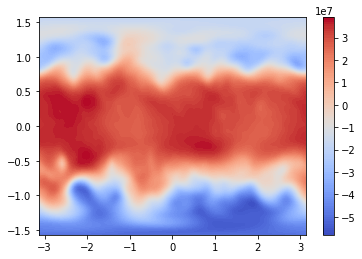

In [16]:
x = np.linspace(xleft, xright, len(lon))
y = np.linspace(ylower, yupper, len(lat))
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, np.reshape(psi0(X.flatten(), Y.flatten()), (len(lat), len(lon))), 100, cmap=plt.cm.coolwarm)
plt.colorbar()
# plt.axis('square')

In [17]:
# Define the normalization layer
class Normalize(tf.keras.layers.Layer):
  def __init__(self, xmin, xmax, name=None, **kwargs):
    super(Normalize, self).__init__(name=name)
    self.xmin = xmin
    self.xmax = xmax
    super(Normalize, self).__init__(**kwargs)

  def call(self, inputs):
    return 2.0*(inputs-self.xmin)/(self.xmax-self.xmin)-1.0

  def get_config(self):
    config = super(Normalize, self).get_config()
    config.update({'xmin': self.xmin, 'xmax': self.xmax})
    return config

In [18]:
class PeriodicSphere(tf.keras.layers.Layer):
  def __init__(self, name=None, **kwargs):
    super(PeriodicSphere, self).__init__(name=name)
    super(PeriodicSphere, self).__init__(**kwargs)

  def call(self, inputs):
    return tf.concat((tf.cos(inputs[1])*tf.cos(inputs[0]),
               tf.cos(inputs[1])*tf.sin(inputs[0]),
               tf.sin(inputs[1])), axis=1)

In [19]:
# Define the network
n_units = 64

inp1 = tf.keras.layers.Input(shape=(1,))
inp2 = tf.keras.layers.Input(shape=(1,))
inp3 = tf.keras.layers.Input(shape=(1,))

# Define the network
inp1 = tf.keras.layers.Input(shape=(1,))
b1 = Normalize(t0, tfinal)(inp1)

inp2 = tf.keras.layers.Input(shape=(1,))
inp3 = tf.keras.layers.Input(shape=(1,))
b23 = PeriodicSphere()([inp2, inp3])

b = tf.keras.layers.Concatenate()([b1, b23])

for i in range(8):
  b = tf.keras.layers.Dense(n_units, 'tanh', 
                            kernel_initializer='glorot_normal')(b)
out = tf.keras.layers.Dense(1, activation='linear')(b)
out = tf.keras.layers.Lambda(lambda x: PSI*x)(out)

model = tf.keras.models.Model([inp1, inp2, inp3], out)
model.summary()

2023-04-12 07:59:07.365586: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 07:59:08.863250: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46886 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:af:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 normalize_1 (Normalize)        (None, 1)            0           ['input_4[0][0]']                
                                                                                              

In [20]:
@tf.function
def train_step(pdes, inits):

  t_pde, x_pde, y_pde = pdes[:,:1], pdes[:,1:2], pdes[:,2:3]

  # Initial value points and associated self-adaptation weights
  t_init, x_init, y_init, psi_init = inits[:,:1], inits[:,1:2], inits[:,2:3], inits[:,3:]

  # Outer gradient for tuning network parameters
  with tf.GradientTape() as tape:

    with tf.GradientTape() as tape3:
      tape3.watch(t_pde), tape3.watch(x_pde), tape3.watch(y_pde)
      with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(t_pde), tape2.watch(x_pde), tape2.watch(y_pde)
        with tf.GradientTape() as tape1:
          tape1.watch(t_pde), tape1.watch(x_pde), tape1.watch(y_pde)
          psi = model([t_pde, x_pde, y_pde])
        [psit, psix, psiy] = tape1.gradient(psi, [t_pde, x_pde, y_pde])
        cosypsiy = tf.cos(y_pde)*psiy
      psixx = tape2.gradient(psix, x_pde)
      cosypsiyy = tape2.gradient(cosypsiy, y_pde)
        
      # Define the non-dimensionalized vorticity
      zeta = 1.0/(a**2*tf.cos(y_pde)**2)*psixx + 1.0/(a**2*tf.cos(y_pde))*cosypsiyy
      
    # Derivatives of the vorticity
    [zetat, zetax, zetay] = tape3.gradient(zeta, [t_pde, x_pde, y_pde])

    # Non-dimensionalized vorticity equation on the sphere
    eqn = zetat + 1.0/(a**2*tf.cos(y_pde))*(psix*zetay-psiy*zetax) + 2.0*Omega/a**2*psix  

    # Define the PDE loss  
    PDEloss = tf.reduce_mean(tf.square(eqn))*(L**2*T/PSI)**2

    # Define the initial value losses
    psi_init_pred = model([t_init, x_init, y_init])
    ICloss = 10*tf.reduce_mean(tf.square(psi_init-psi_init_pred))/PSI**2

    # Global loss
    loss = PDEloss + ICloss

  # Compute the gradient of the global loss wrt the model parameters
  grads = tape.gradient(loss, model.trainable_weights)

  return grads, PDEloss, ICloss 

In [21]:
def PNNtrain(t_bdry, x_bdry, y_bdry, psi0, epochs=2000, N_pde=100000, N_iv=10000):

  bs_pdes, bs_inits = N_pde//50, N_iv//50

  # Optimizer to be used
  opt = tf.keras.optimizers.Adam()

  # Sample points where to evaluate the PDE
  txy_min = np.array([t_bdry[0], x_bdry[0], 0])
  txy_max = np.array([t_bdry[1], x_bdry[1], 1])  
  pde_points = txy_min + (txy_max - txy_min)*lhs(3, N_pde)
  t_pde = pde_points[:, 0] 
  x_pde = pde_points[:, 1]
  y_pde = np.arccos(1-2*pde_points[:, 2]) - np.pi/2
  
  # Stack all the PDE point data together
  pdes = np.column_stack([t_pde, x_pde, y_pde]).astype(np.float32)
  pdes = pdes[np.argsort(pdes[:,0])]  

  # Uniform random sampling on a sphere for initial values
  init_points = txy_min[1:] + (txy_max[1:] - txy_min[1:])*lhs(2, N_iv)
  x_init = init_points[:, 0]
  y_init = np.arccos(1-2*init_points[:, 1]) - np.pi/2
  t_init = t_bdry[0]+0*x_init

  psi_init = np.expand_dims(psi0(x_init, y_init), axis=1)

  # Stack all the ivp data together
  inits = np.column_stack([t_init, x_init, y_init, psi_init]).astype(np.float32)
  
  ds_pde = tf.data.Dataset.from_tensor_slices(pdes)
  ds_pde = ds_pde.cache().shuffle(N_pde).batch(bs_pdes)

  ds_init = tf.data.Dataset.from_tensor_slices(inits)
  ds_init = ds_init.cache().shuffle(N_iv).batch(bs_inits)

  ds = tf.data.Dataset.zip((ds_pde, ds_init))
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

  epoch_loss = np.zeros(epochs)

  # Main training loop
  for i in range(epochs):

    n_batches = 0

    for (pdes, inits) in ds:

      grads, PDEloss, ICloss = train_step(pdes, inits)
      opt.apply_gradients(zip(grads, model.trainable_weights))

      n_batches += 1
      epoch_loss[i] += PDEloss + ICloss
    
    epoch_loss[i] /= n_batches

    if (np.mod(i, 100)==0):
      print(f"Total loss, PDE loss, IV loss {i}th epoch: {epoch_loss[i]: 6.4g}, {PDEloss.numpy(): 6.4g}, {ICloss.numpy(): 6.4g}.")

  return epoch_loss

In [22]:
loss = PNNtrain([t0, tfinal], [xleft, xright], [ylower, yupper], psi0)

2023-04-12 07:59:36.155777: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x2140c3c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-12 07:59:36.156581: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-04-12 07:59:36.199136: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-12 07:59:36.986631: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Total loss, PDE loss, IV loss 0th epoch:  0.3975,  0.002773,  0.02648.
Total loss, PDE loss, IV loss 100th epoch:  0.004634,  0.0001099,  0.004043.
Total loss, PDE loss, IV loss 200th epoch:  0.00349,  0.0003941,  0.004014.
Total loss, PDE loss, IV loss 300th epoch:  0.002034,  0.000518,  0.001369.
Total loss, PDE loss, IV loss 400th epoch:  0.001559,  0.0006216,  0.001171.
Total loss, PDE loss, IV loss 500th epoch:  0.001391,  0.0003998,  0.001326.
Total loss, PDE loss, IV loss 600th epoch:  0.001167,  0.0003674,  0.0009005.
Total loss, PDE loss, IV loss 700th epoch:  0.001086,  0.0002764,  0.0008744.
Total loss, PDE loss, IV loss 800th epoch:  0.00119,  0.0003714,  0.0007189.
Total loss, PDE loss, IV loss 900th epoch:  0.001061,  0.0002353,  0.000551.
Total loss, PDE loss, IV loss 1000th epoch:  0.001035,  0.0002338,  0.0005952.
Total loss, PDE loss, IV loss 1100th epoch:  0.0009039,  0.0002063,  0.0005951.
Total loss, PDE loss, IV loss 1200th epoch:  0.000874,  0.0003335,  0.0007433

In [23]:
# Grid where to evaluate the model
l, m, n = 5, len(lon), len(lat)
tt = np.linspace(t0, tfinal, l)
x = np.linspace(xleft, xright, m)
y = np.linspace(ylower, yupper, n)
TT, Y, X  = np.meshgrid(tt, y, x, indexing='ij')

dt = t[1]-t[0]

psi = model([np.expand_dims(TT.flatten(), axis=1), 
           np.expand_dims(X.flatten(), axis=1),
           np.expand_dims(Y.flatten(), axis=1)])
psi = np.reshape(psi, (l, n, m))

In [24]:
psi = np.flip(psi, axis = 1)

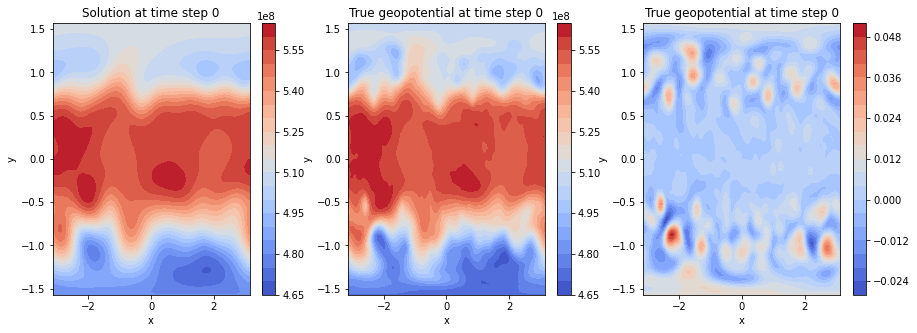

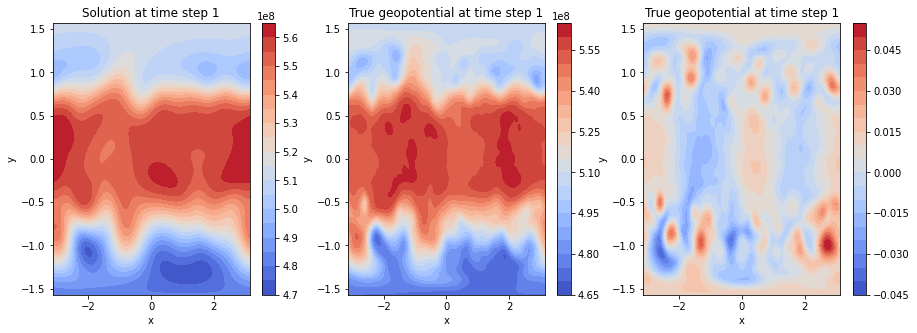

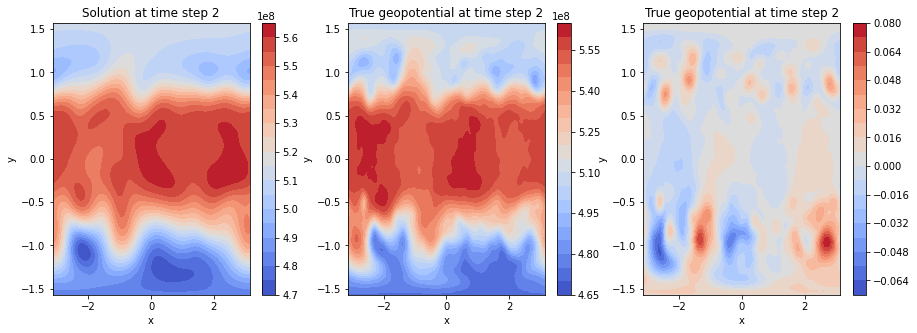

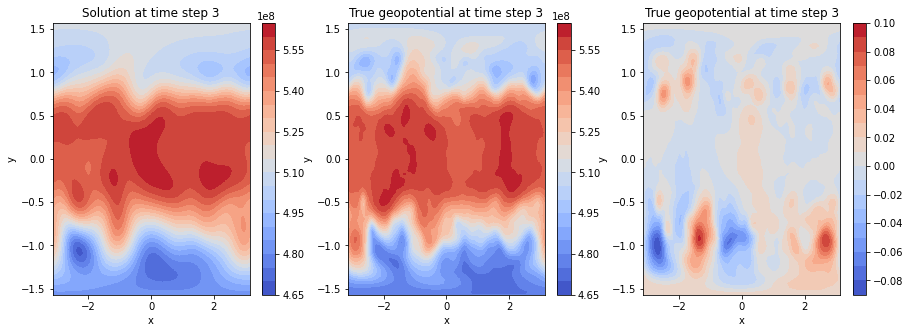

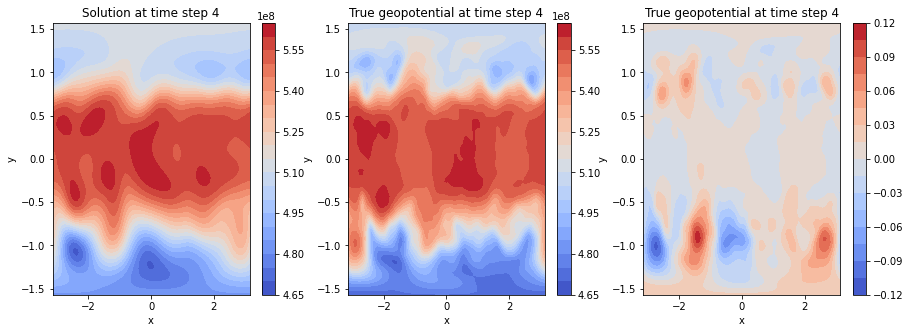

In [25]:
dt = tfinal/(l-1)

for i in range(l):
  plt.figure(figsize=(15,5))

  plt.subplot(131)
  # nu = (R*(3+R)*omega - 2*Omega/tau)/((1+R)*(2+R))
  # geo[i, :, :] = psi0(X[i,]-nu*i*dt, Y[i,])
  # geo[i, :, :] = np.flip(geo[i,:,:], axis = 0)/c

  psi_pred = psi[i,] + np.mean(geo[0,])
  
  mdic = {"psi": psi_pred}
  savemat("psi_"+str(i)+".mat", mdic)

  plt.contourf(lon, lat, psi_pred, 20, cmap=plt.cm.coolwarm)
  plt.colorbar() 
  
  # plt.axis('square')
  plt.title('Solution at time step {}'.format(i))
  plt.xlabel('x')
  plt.ylabel('y')


  plt.subplot(132)
  plt.contourf(lon, lat, geo[i, :, :], 20, cmap=plt.cm.coolwarm)
  plt.colorbar()
  plt.title('True geopotential at time step {}'.format(i))
  plt.xlabel('x')
  plt.ylabel('y')

  plt.subplot(133)
  plt.contourf(lon, lat, (psi_pred-geo[i, :, :])/geo[i, :, :], 20, cmap=plt.cm.coolwarm)
  # plt.contourf(lon, lat, (psi_pred-geo[i, :, :]), 20, cmap=plt.cm.coolwarm)
  plt.colorbar()
  plt.title('True geopotential at time step {}'.format(i))
  plt.xlabel('x')
  plt.ylabel('y')

  plt.show()